# Case study: Independent Component Analysis
Fig. 6d

In [ ]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import gridspec
from sklearn.decomposition import FastICA

from causalchamber.ground_truth import latex_name


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:TODO},
  year={2024}
}



### Auxiliary functions

#### Plotting

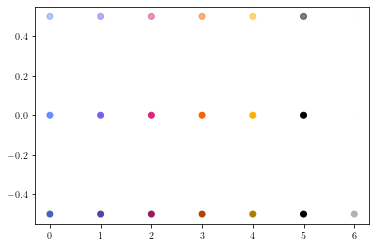

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

matplotlib.rcParams.update({'font.size': 7})

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

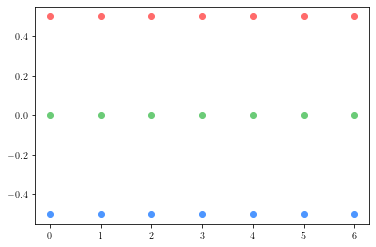

In [5]:
# RGB palette for some of the plots

cred = "#FF6B6B"
cgreen = "#6BCB77"
cblue = "#4D96FF"
plt.scatter(np.arange(len(base)), np.zeros(len(base)), color=cgreen)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, color=cred)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, color=cblue)

In [6]:
def norm(x):
    xx = x - x.min()
    return xx / xx.max()

In [7]:
MM = 1/25.4

#### To assign each original signal to its closest reconstruction

(closest = largest sample correlation coefficient)

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
def assignments(truths, estimates):
    k = truths.shape[1]
    l = estimates.shape[1]
    corrs = np.zeros((k,l))
    signs = np.zeros((k,l))
    for i in range(k):        
        truth = truths[:,i]
        for j in range(l):
            estimate = estimates[:,j].reshape(-1,1)
            reg = LinearRegression().fit(estimate, truth)
            signs[i,j] = np.sign(reg.coef_)            
            corrs[i,j] = abs(np.corrcoef(truth, estimates[:,j])[0,1])
    idx = corrs.argmax(axis=1)
    return idx, [s[i] for i,s in zip(idx,signs)]    

## Task A: Disentangling the light-source color ($R,G,B$) from the light-intensity measurements

### Download dataset

In [10]:
from causalchamber import datasets
dataset = datasets.Dataset(name="lt_walks_v1", root="/tmp")
df_all = dataset.get_experiment("color_mix").as_pandas_dataframe()

Dataset lt_walks_v1 found in "/tmp/lt_walks_v1".


### Run FastICA and plot results

[2 3 4]


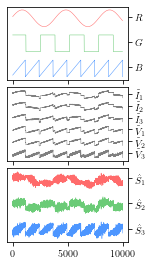

In [11]:
inputs = ['ir_1', 'ir_2', 'ir_3', 'vis_1', 'vis_2', 'vis_3']
intensities = df_all[inputs].values
colors = df_all[['red', 'green', 'blue']].values
X = intensities
S = colors

# Compute ICA
ica = FastICA(n_components=len(inputs), whiten="unit-variance")
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# Plot results
plt.figure(figsize=(55*MM,110*MM))
gs = gridspec.GridSpec(3, 1, wspace=0, hspace=0.1)
kwargs = {'linewidth': 0.5}

# Sources
plt.subplot(gs[0])
ax = plt.gca()
ax.plot(df_all.red/255, color=cred, **kwargs)
ax.plot(df_all.green/255-1.5, color=cgreen, **kwargs)
ax.plot(df_all.blue/255-3, color=cblue, **kwargs)
ax.set_xticklabels([])
plt.yticks(np.array([0,-1.5,-3])+0.6, ['$R$', '$G$', '$B$'])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.subplot(gs[1])
ax = plt.gca()
for i,c in enumerate(inputs):
    ax.plot(norm(df_all[c])-i*1.5, color="gray", **kwargs)
ax.set_xticklabels([])
#plt.title("Light-intensity readings")
plt.yticks(-np.arange(len(inputs)) * 1.5 + 0.6, [latex_name(i) for i in inputs])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.subplot(gs[2])
truths = df_all[['red', 'green', 'blue']].values
idx, signs = assignments(truths, S_)
print(idx)
ax = plt.gca()
ax.plot(norm(signs[0] * S_[:,idx[0]]), color=cred, **kwargs)
ax.plot(norm(signs[1] * S_[:,idx[1]])-1.5, color=cgreen, **kwargs)
ax.plot(norm(signs[2] * S_[:,idx[2]])-3, color=cblue, **kwargs)
plt.yticks(np.array([0,-1.5,-3])+0.6, [r'$\hat{S}_1$', r'$\hat{S}_2$', r'$\hat{S}_3$'])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

#plt.title("FastICA output")
plt.savefig("../figures/ica_color.pdf", bbox_inches="tight")

## Task B: Disentangling fan loads from pressure measurements

### Download dataset

In [12]:
from causalchamber import datasets
dataset = datasets.Dataset(name="wt_walks_v1", root="/tmp")
df_all = dataset.get_experiment("loads_hatch_mix_slow_run_1").as_pandas_dataframe()

Dataset wt_walks_v1 found in "/tmp/wt_walks_v1".


### Run FastICA and plot results

[1 3 0]


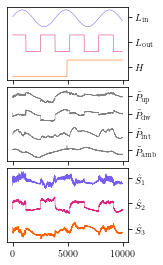

In [13]:
# Setup
inputs = ['pressure_upwind', 'pressure_downwind', 'pressure_intake', 'pressure_ambient']
#inputs = ['pressure_downwind', 'rpm_in', 'rpm_out']
X = df_all[inputs].values

# Compute ICA
ica = FastICA(n_components=len(inputs), whiten="unit-variance", random_state=1)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

plt.figure(figsize=(55*MM,110*MM))
gs = gridspec.GridSpec(3, 1, wspace=0, hspace=0.1)
kwargs = {'linewidth': 0.5}

# Sources
plt.subplot(gs[0])
ax = plt.gca()
ax.plot(norm(df_all.load_in), color=base[1], **kwargs)
ax.plot(norm(df_all.load_out)-1.5, color=base[2], **kwargs)
ax.plot(norm(df_all.hatch)-3, color=base[3], **kwargs)
#ax.plot(norm(df_all.pressure_ambient)-4.5, color=base[3], **kwargs)
ax.set_xticklabels([])
plt.yticks(np.array([0,-1.5,-3])+0.6, [r'$L_\text{in}$', r'$L_\text{out}$', '$H$'])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.subplot(gs[1])
ax = plt.gca()
for i,c in enumerate(inputs):
    ax.plot(norm(df_all[c])-i*1.5, color="gray", **kwargs)
ax.set_xticklabels([])
#plt.title("Light-intensity readings")
plt.yticks(-np.arange(len(inputs)) * 1.5 + 0.6, [latex_name(i) for i in inputs])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.subplot(gs[2])
ax = plt.gca()
truths = df_all[['load_in', 'load_out', 'hatch']].values
idx, signs = assignments(truths, S_)
print(idx)
ax.plot(norm(signs[0] * S_[:,idx[0]]), color=base[1], **kwargs)
ax.plot(norm(signs[1] * S_[:,idx[1]])-1.5, color=base[2], **kwargs)
ax.plot(norm(signs[2] * S_[:,idx[2]])-3, color=base[3], **kwargs)
#ax.plot(norm(signs[3] * S_[:,idx[3]])-4.5, color=base[4], **kwargs)
plt.yticks(np.array([0,-1.5,-3])+0.6, [r'$\hat{S}_1$', r'$\hat{S}_2$', r'$\hat{S}_3$'])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

#plt.title("FastICA output")

plt.savefig("../figures/ica_pressures.pdf", bbox_inches="tight")

## Task C: Actuators from images

### Download dataset

In [14]:
from causalchamber import datasets
dataset = datasets.Dataset(name="lt_camera_walks_v1", root="/tmp")
dataset.available_experiments()

Dataset lt_camera_walks_v1 found in "/tmp/lt_camera_walks_v1".


['color_mix', 'actuator_mix']

### Run FastICA on flattened images

In [15]:
exp = dataset.get_experiment('actuator_mix')
images = exp.as_image_array('50')

CPU times: user 22min 11s, sys: 1min 40s, total: 23min 52s
Wall time: 3min 10s


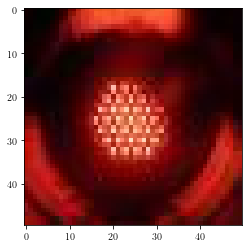

In [16]:
%%time

flat = images.reshape((10000,7500))
reshaped = flat.reshape(10000,50,50,3)
plt.imshow(reshaped[10])

X = flat
# Compute ICA
ica = FastICA(n_components=5, whiten="unit-variance")
S_ = ica.fit_transform(X)  # Reconstruct signals

Check recovery after inverting transformation

(10000, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10000, 7500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


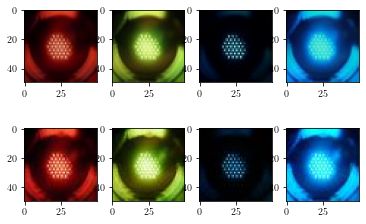

In [17]:
print(S_.shape)
flat_ica = ica.inverse_transform(S_)
print(flat_ica.shape)
reshaped_ica = flat_ica.reshape(10000,50,50,3)

i = 10
plt.subplot(241)
plt.imshow(reshaped_ica[i] / reshaped_ica[i].max())
plt.subplot(245)
plt.imshow(images[i])

plt.subplot(242)
i = 1000
plt.imshow(reshaped_ica[i] / reshaped_ica[i].max())
plt.subplot(246)
plt.imshow(images[i])

plt.subplot(243)
i = 2000
plt.imshow(reshaped_ica[i] / reshaped_ica[i].max())
plt.subplot(247)
plt.imshow(images[i])

plt.subplot(244)
i = 3000
plt.imshow(reshaped_ica[i] / reshaped_ica[i].max())
plt.subplot(248)
plt.imshow(images[i])

### Plot results

[3 0 1 2 2]


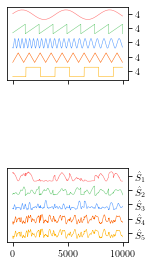

In [18]:
df_all = exp.as_pandas_dataframe()
truth_fields = ['red', 'green', 'blue', 'pol_1', 'pol_2']

# Plot results
plt.figure(figsize=(55*MM,110*MM))
gs = gridspec.GridSpec(3, 1, wspace=0, hspace=0.1)
kwargs = {'linewidth': 0.5}

# Sources
plt.subplot(gs[0])
ax = plt.gca()
colors = [cred, cgreen, cblue, base[3], base[4]]
for i,f in enumerate(truth_fields):
    ax.plot(norm(df_all[f])-i*1.5, color=colors[i], **kwargs)
ax.set_xticklabels([])
plt.yticks(np.arange(len(truth_fields)) * (-1.5) + 0.6, [latex_name(i) for f in truth_fields])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.subplot(gs[2])
truths = df_all[truth_fields].values
idx, signs = assignments(truths, S_)
print(idx)
ax = plt.gca()
for i,f in enumerate(truth_fields):
    ax.plot(norm(signs[i] * S_[:,idx[i]])-i*1.5, color=colors[i], **kwargs)
plt.yticks(np.arange(len(truth_fields)) * (-1.5) + 0.6, [r"$\hat{S}_%d$" % (i+1) for i in range(len(truth_fields))])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

#plt.title("FastICA output")
plt.savefig("../figures/ica_images.pdf", bbox_inches="tight")

### Additional images for plots

In [19]:
exp = dataset.get_experiment('actuator_mix')
images200 = exp.as_image_array('200')

0 1705100311.jpg
1999 1705103589.jpg
3999 1705106870.jpg
5999 1705110149.jpg
7999 1705113430.jpg
9999 1705116709.jpg


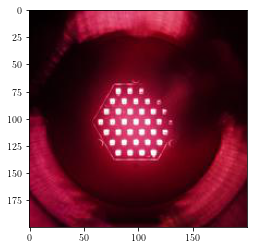

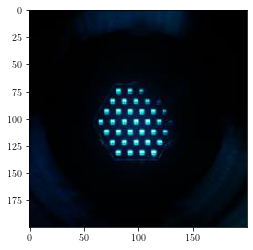

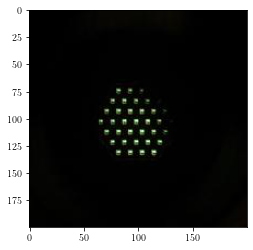

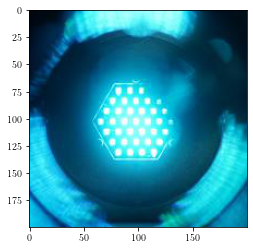

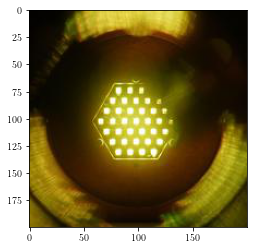

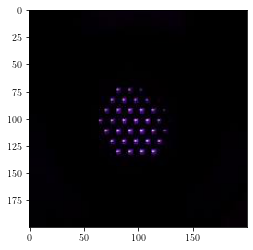

In [20]:
idx = np.linspace(0,9999,6).astype(int)
for i in idx:
    print(i,df_all.iloc[i].image_file)
    plt.figure()
    plt.imshow(images200[i])

### A simple but good approximation for the mean of each image

- Take each channel (R,G,B) and apply Malus' law
- Could go further considering that the polarizers affect each color differently (e.g. they block more of the red light)

Dataset lt_camera_walks_v1 found in "/tmp/lt_camera_walks_v1".


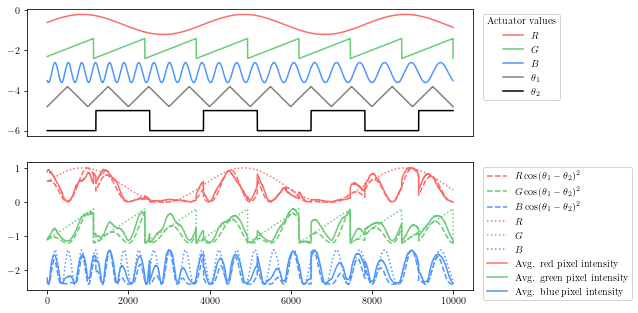

In [21]:
from causalchamber import datasets
dataset = datasets.Dataset(name="lt_camera_walks_v1", root="/tmp")
exp = dataset.get_experiment('actuator_mix')

images = exp.as_image_array('50')
df = exp.as_pandas_dataframe()

color_means = images.mean(axis=(1,2))

plt.figure(figsize=(8,8))
plt.subplot(311)
malus = np.cos((df.pol_1 - df.pol_2) / 180 * np.pi)**2
plt.plot(norm(df.red)-1.2, color=cred, label="$R$")
plt.plot(norm(df.green)-2.4, color=cgreen, label="$G$")
plt.plot(norm(df.blue)-3.6, color=cblue, label="$B$")
plt.plot(norm(df.pol_1)-4.8, color='gray', label=r"$\theta_1$")
plt.plot(norm(df.pol_2)-6, color='black', label=r"$\theta_2$")
plt.legend(bbox_to_anchor = (1.01,1), loc="upper left", title="Actuator values")
plt.xticks([])

plt.subplot(312)
plt.plot(norm(df.red*malus), color=cred, linestyle="--", label=r"$R \cos(\theta_1 - \theta_2)^2$")
plt.plot(norm(df.green*malus)-1.2, color=cgreen, linestyle="--", label=r"$G \cos(\theta_1 - \theta_2)^2$")
plt.plot(norm(df.blue*malus)-2.4, color=cblue, linestyle="--", label=r"$B \cos(\theta_1 - \theta_2)^2$")
plt.plot(norm(df.red), color=cred, linestyle=":", label=r"$R$")
plt.plot(norm(df.green)-1.2, color=cgreen, linestyle=":", label=r"$G$")
plt.plot(norm(df.blue)-2.4, color=cblue, linestyle=":", label=r"$B$")

#plt.xticks([])

#plt.subplot(313)
plt.plot(norm(color_means[:,0]), color=cred, label="Avg. red pixel intensity")
plt.plot(norm(color_means[:,1])-1.2, color=cgreen, label="Avg. green pixel intensity")
plt.plot(norm(color_means[:,2])-2.4, color=cblue, label="Avg. blue pixel intensity")
plt.legend(bbox_to_anchor = (1.01,1), loc="upper left")